# Analysis and Visualization of ChIP-Seq data with Deeptools and Coolbox

## Introduction to ChIP-Seq
### What is ChIP-seq?
* ChIP-Seq stands for **Ch**romatin **I**mmunopreci**P**itation followed by **Seq**uencing.
* It is used to study the interactions of proteins with DNA. Specifically, ChIP-Seq is used to map DNA-binding proteins and histone modifications in a genome-wide manner at base-pair resolution. 
* To eliminate bias in fragmentation and sequencing, a control sample (generally called input DNA) is also sequenced to compare against the experimental condition.  Input control is DNA purified from cells that are cross-linked, frag- mented, but without adding any antibody for enrichment

### How are RNA-Seq studies different from ChIP-Seq studies?
* The DNA fragments coming from a ChIP-Seq study are much shorter than a transcript studied in RNA-Seq analysis.
* The DNA fragments of a ChIP-Seq experiment are less localized than transcripts. 
* ChIP-Seq data produces a more significant number of false positives. ChIP-Seq protocols strongly depend on the properties of the reagents, selectivity, and specificity of the binding process, and these properties will vary across different proteins and across the genome.

### What are the processing steps for ChIP-Seq data?
* Generate or obtain sequencing read data.
* Align sequences to a reference genome.
* Coduct QC of data
* Visualize signal coverage across the genome
* Call peaks from alignment files if desired

## Creating bigWig files for ChIP-Seq data visualization
### A note about file formats
* Sequencing raw data are usually available in FASTA/FASTQ formats, deposited in the SRA database.
* These raw data must be first indexed and sorted into `.bam.bai` files.
* Next BAM files are converted into the bigWig file format. The bigWig format is for display of dense, continuous data that will be displayed as a graph. See [here](http://genome.ucsc.edu/goldenPath/help/bigWig.html) for more information.

### Creating bigWig files from raw read data
Below, we will go through an example starting from raw ChIP-Seq data deposited in the SRA database and converting it to a bigWig file that can be used to visualize ChIP signals across the genome! We will recreate some of the analysis from [Tsankov et. al (Nature 2015)](https://www.nature.com/articles/nature14233) which reported the genome-wide binding data for 38 transcription factors with extensive epigenome and transcriptional data across the differentiation of human embryonic stem cells to the three germ layers. The raw data can be accessed from the Gene Expression Omnibus (GEO) database [GSE61475](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE61475) or Bioproject [PRJNA261253](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA261253).

We will be analyzing the following files: SRR1576335, SRR1576337, SRR1576338, SRR1576340, SRR1576341 which contain Nanog binding data for human embryonic stem cells and the three germ layers.

#### Fetch raw sequence data files

In [ ]:
# Run the following commands in terminal:
cd ~                                                          # navigate to your home directory
mkdir -p ChIP-seq/{data,results,refs}                         # create directories to store data and result files
cd ChIP-seq/data/                                             # move to your data folder

# create a text file to store the SRRids of interest (called list.txt here)
cat list.txt | parallel fastq-dump --split-files {}           # download datasets, separating paired reads with split-files

In [ ]:
## optional method to download all NANOG ChIP-Seq files in project PRJNA261253
PROJECT=PRJNA261253
KEYWORD=NANOG
esearch -db sra -query $PROJECT   | esummary > summary.xml
cat summary.xml | xtract -pattern DocumentSummary -element Run@acc Title > summary.txt 
cat summary.txt | grep $KEYWORD | cut -f 1 > runids.txt
cat runids.txt | parallel fastq-dump --split-files {} 

In [ ]:
# rename files for easier analysis ( we are only using 1 of the paired read files for each run for this demo)
mv SRR1576335_1.fastq dME_Nanog.fastq
mv SRR1576337_1.fastq HUES64_rep1_Nanog.fastq
mv SRR1576338_1.fastq HUES64_rep2_Nanog.fastq
mv SRR1576340_1.fastq dEN_Nanog.fastq
mv SRR1576341_1.fastq dEC_Nanog.fastq

#### Build the reference genome

In [ ]:
# now get or build the hg19 reference human genome

# Option 1 - get bowtie1 pre-built hg19 from https://bowtie-bio.sourceforge.net/index.shtml

# Option 2 - build and index it yourself

# download individual files and chromosome size data
URL=http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/chromFa.tar.gz
curl $URL | tar zxv
curl http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes > refs/hg19.chrom.sizes

# concatenate all chromosomes together
mv *.fa refs/  # move all untarred fasta files to the refs folder
REF=refs/hg19.fa
cat refs/chr*.fa > $REF

# on Quest load bowtie 1 and build your reference genome with it
module load bowtie/1.2.2 # for short reads < 50bp, bowtie1 is preferred
bowtie-build $REF bowtie_hg19

#### Align ChIP-Seq data to the reference genome

In [ ]:
# now align chip-seq reads to indexed genome to create SAM files
# create names.txt to hold sample names -- dME_Nanog etc
BASENAME=bowtie_hg19
cat names.txt | parallel bowtie -p 10 --best --chunkmbs 320 $BASENAME -q data/{}.fastq -S results/bams/{}.sam

In [ ]:
# convert sam to sorted bam files
cat names.txt | parallel samtools sort results/bams/{}.sam -o results/bams/{}.bam
# index bam files to get .bam.bai files
cat names.txt | parallel samtools index results/bams/{}.bam

# optional remove sam files since they are large and no longer needed 
rm results/bams/*sam

## Deeptools

Deeptools can be loaded on Quest using the command `module load deeptools/3.5.1`<br>
To use the python package API install the deeptools package using conda or pip. <br>
Deeptools can be used for file processing, quality control and data visualization as shown below.

<font size=4>__Deeptools for file processing__</font>

- `multiBigwigSummary` Given typically two or more bigWig files, multiBigwigSummary computes the average scores for each of the files in every genomic region. This analysis is performed for the entire genome by running the program in bins mode, or for certain user selected regions in BED-file mode. Most commonly, the default output of multiBigwigSummary (a compressed numpy array, .npz) is used by other tools such as plotCorrelation or plotPCA for visualization and diagnostic purposes.
- `correctGCBias` This tool corrects the GC-bias using the method proposed by Benjamini & Speed (2012). Nucleic Acids Research, 40(10). It will remove reads from regions with too high coverage compared to the expected values (typically GC-rich regions) and will add reads to regions where too few reads are seen (typically AT-rich regions). The tool computeGCBias needs to be run first to generate the frequency table needed here.
- `bamCoverage` This tool takes an alignment of reads or fragments as input (BAM file) and generates a coverage track (bigWig or bedGraph) as output. The coverage is calculated as the number of reads per bin, where bins are short consecutive counting windows of a defined size. 
- `bigwigCompare` This tool compares two bigWig files based on the number of mapped reads. To compare the bigWig files, the genome is partitioned into bins of equal size, then the number of reads found in each BAM file are counted per bin and finally a summary value is reported. This value can be the ratio of the number of readsper bin, the log2 of the ratio, the sum or the difference.
- `computeMatrix` This tool calculates scores per genome regions and prepares an intermediate file that can be used with plotHeatmap and plotProfiles. Typically, the genome regions are genes, but any other regions defined in a BED file can be used. computeMatrix accepts multiple score files (bigWig format) and multiple regions files (BED format). This tool can also be used to filter and sort regions according to their score.

<font size=4>__Deeptools for Quality Control__</font>

- `plotCorrelation` Tool for the analysis and visualization of sample correlations based on the output of multiBamSummary or multiBigwigSummary. Pearson or Spearman methods are available to compute correlation coefficients. Results can be saved as multiple scatter plots depicting the pairwise correlations or as a clustered heatmap, where the colors represent the correlation coefficients and the clusters are constructed using complete linkage. Optionally, the values can be saved as tables, too.
- `plotPCA` Tool for generating a principal component analysis (PCA) plot from multiBamSummary or multiBigwigSummary output. By default, the loadings for each sample in each principal component is plotted. If the data is transposed, the projections of each sample on the requested principal components is plotted instead.
- `plotFingerprint` This tool samples indexed BAM files and plots a profile of cumulative read coverages for each. All reads overlapping a window (bin) of the specified length are counted; these counts are sorted and the cumulative sum is finally plotted.
- `bamPEFragmentSize` This tool calculates the fragment sizes for read pairs given a BAM file from paired-end sequencing.Several regions are sampled depending on the size of the genome and number of processors to estimate thesummary statistics on the fragment lengths. Properly paired reads are preferred for computation, i.e., it will only use discordant pairs if no concordant alignments overlap with a given region. The default setting simply prints the summary statistics to the screen.
- `computeGCBias` Computes the GC-bias using Benjamini’s method [Benjamini & Speed (2012). Nucleic Acids Research, 40(10). doi: 10.1093/nar/gks001]. The GC-bias is visualized and the resulting table can be used tocorrect the bias with correctGCBias.
- `plotCoverage` This tool is useful to assess the sequencing depth of a given sample. It samples 1 million bp, counts the number of overlapping reads and can report a histogram that tells you how many bases are covered how many times. Multiple BAM files are accepted, but they all should correspond to the same genome assembly.

<font size=4>__Deeptools for data visualization__</font>

- `plotHeatmap` This tool creates a heatmap for scores associated with genomic regions. The program requires a matrix file generated by the tool computeMatrix.
- `plotProfile` This tool creates a profile plot for scores over sets of genomic regions. Typically, these regions are genes, but any other regions defined in BED will work. A matrix generated by computeMatrix is required.
- `plotEnrichment` Tool for calculating and plotting the signal enrichment in either regions in BED format or feature types (column 3) in GTF format. The underlying datapoints can also be output. Metrics are plotted as a fraction of total reads. Regions in a BED file are assigned to the ‘peak’ feature.

### Example: Assay for batch effects with PCA
QC is an important part of any biological experiment. To ensure that replicate conditions across batches are more similar to each other than distinct conditions from the same batch, we will run a PCA.

- Use `bamCoverage` to generate bigWig files from bam input files
- Use `multiBigwigSummary` to compute the average scores for each of the files in every genomic region
- Use `plotPCA` to visualize the summary data

In [ ]:
# load deeptools on Quest
module load deeptools/3.5.1

# create a file called "names.txt" which contains all the experiment file names. In this case names.txt looks like this-
HUES64_rep1_Nanog
HUES64_rep2_Nanog
dEC_Nanog
dEN_Nanog
dME_Nanog

# to get bedgraph files which are human readable
cat names.txt | parallel bamCoverage --bam results/bams/{}.bam \
-o results/bams/{}.SeqDepthNorm.bw --outFileFormat bedgraph

# to get bigWig files for graphing later
cat names.txt | parallel bamCoverage -b results/bams/{}.bam \
--normalizeUsing RPKM \
--binSize 30 \
--smoothLength 300 \
-p 10 \
--extendReads 200 \
-o results/bams/{}.bw

In [ ]:
# run  multiBigwigSummary
# The default output of multiBamSummary (a compressed numpy array: `*.npz`) can be visualized using plotCorrelation or plotPCA
multiBigwigSummary bins \
-b results/bams/*Nanog.bw \
-o multibigwigsummary.npz

In [ ]:
plotPCA -in multibigwigsummary.npz \
-o plotPCAoutput.png \
-T "PCA of read counts"

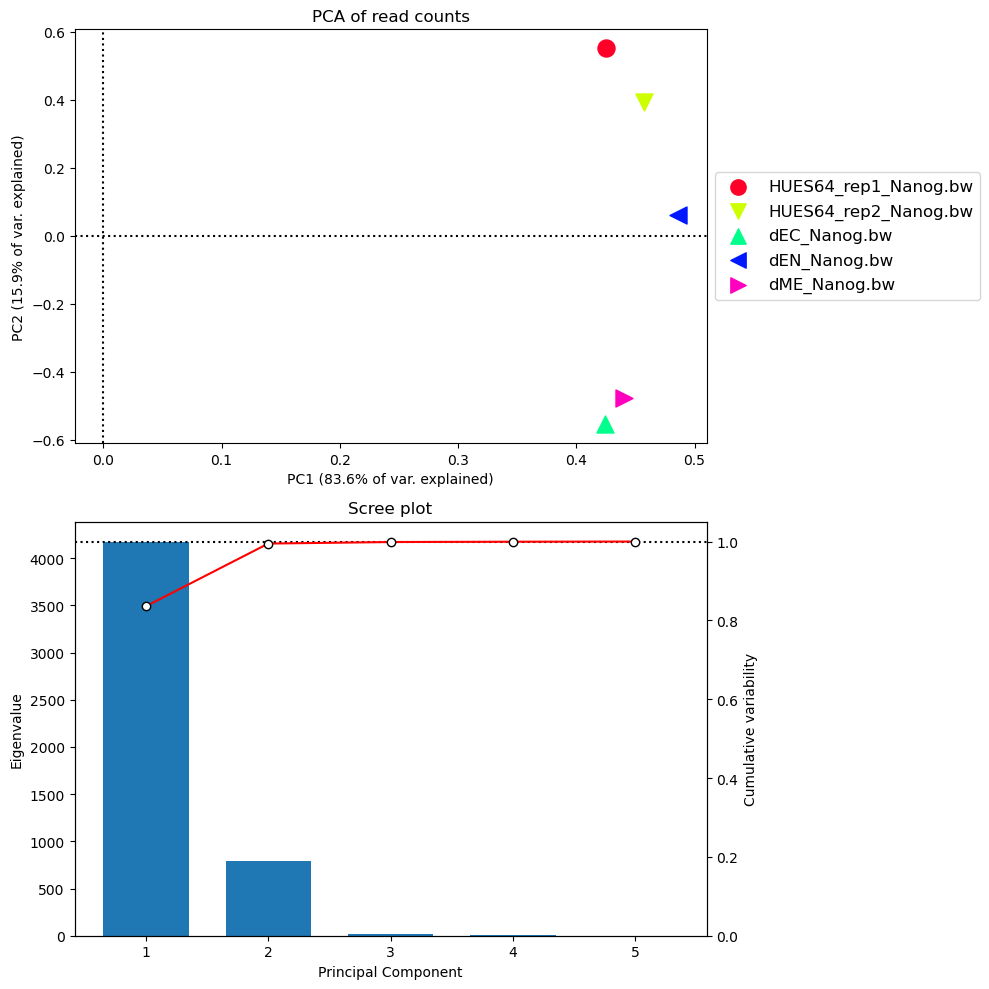

In [24]:
from IPython.display import Image
Image("ChIP-seq/plotPCAoutput.png",  embed=True, width=800)

### Example: Plot the binding profile of your ChIP'ed protein to the genomic transcription start sites for one experiment
Since we are looking at the transcription factor Nanog, we might want to map it's enrichment on TSS regions.

- Obtain an annotated gene regions file which will contain TSS feature information for your reference genome
- Use `computeMatrix` to calculate scores per genome regions and prepare an intermediate file that can be used with plotHeatmap and plotProfiles. 
- Use `plotProfile` to plot scores over sets of genomic regions. 
- Use `plotHeatmap` to visualize the heatmap for scores associated with genomic regions

In [ ]:
# get the gencode annotation file for hg19 reference genome
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz

# compute TSS BED file from it
zcat gencode.v19.annotation.gtf.gz | \
awk 'OFS="\t" {if ($3=="transcript") {if ($7 == "+") {print $1,$4-1,$4,$12,".",$7} else {print $1,$5-1,$5,$12,".",$7}}}'\
| tr -d '";' \
| sort -k1,1V -k2,2n > gencode.v19.annotation.tss.bed

In [ ]:
# compute Matrix with output outFileSortedRegions in BED format to display in an annotation track

computeMatrix reference-point --referencePoint TSS \
-b 1000 -a 1000 \
-R gencode.v19.annotation.tss.bed \
-S results/bams/*Nanog.bw \
--skipZeros \
-o results/matrixNanog_TSS.gz \
-p 6 \
--outFileSortedRegions results/regions_TSS.bed

<font size=3>__Compute the matrix for Nanog binding to TSS in differentiated ectodermal cells whose data is contained in file `dEC_Nanog.bw`__</font>

In [ ]:
# compute Matrix with output matrix needed for plotting profiles and heatmaps
computeMatrix reference-point --referencePoint TSS \
-b 1000 -a 1000 \
-S results/bams/dEC_Nanog.bw \
-R gencode.v19.annotation.tss.bed \
--skipZeros \
--numberOfProcessors 16 \
-o dEC_Nanog_matrix.mat.gz

In [ ]:
# plot profile
plotProfile -m dEC_Nanog_matrix.mat.gz -out plotProfile_dEC_Nanog.png

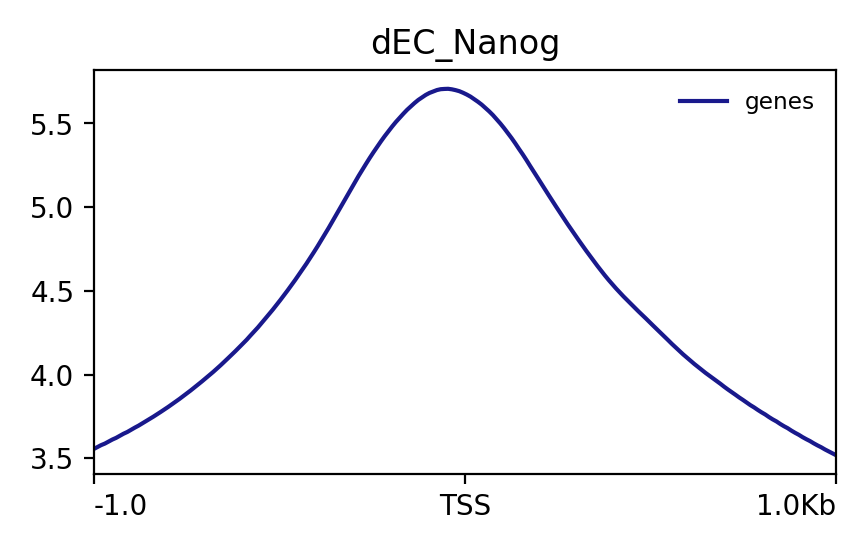

In [14]:
Image("ChIP-seq/plotProfile_dEC_Nanog.png", embed=True, retina=True)

In [ ]:
# plot heatmap
plotHeatmap -m dEC_Nanog_matrix.mat.gz -out plotHeatmap_dEC_Nanog.png

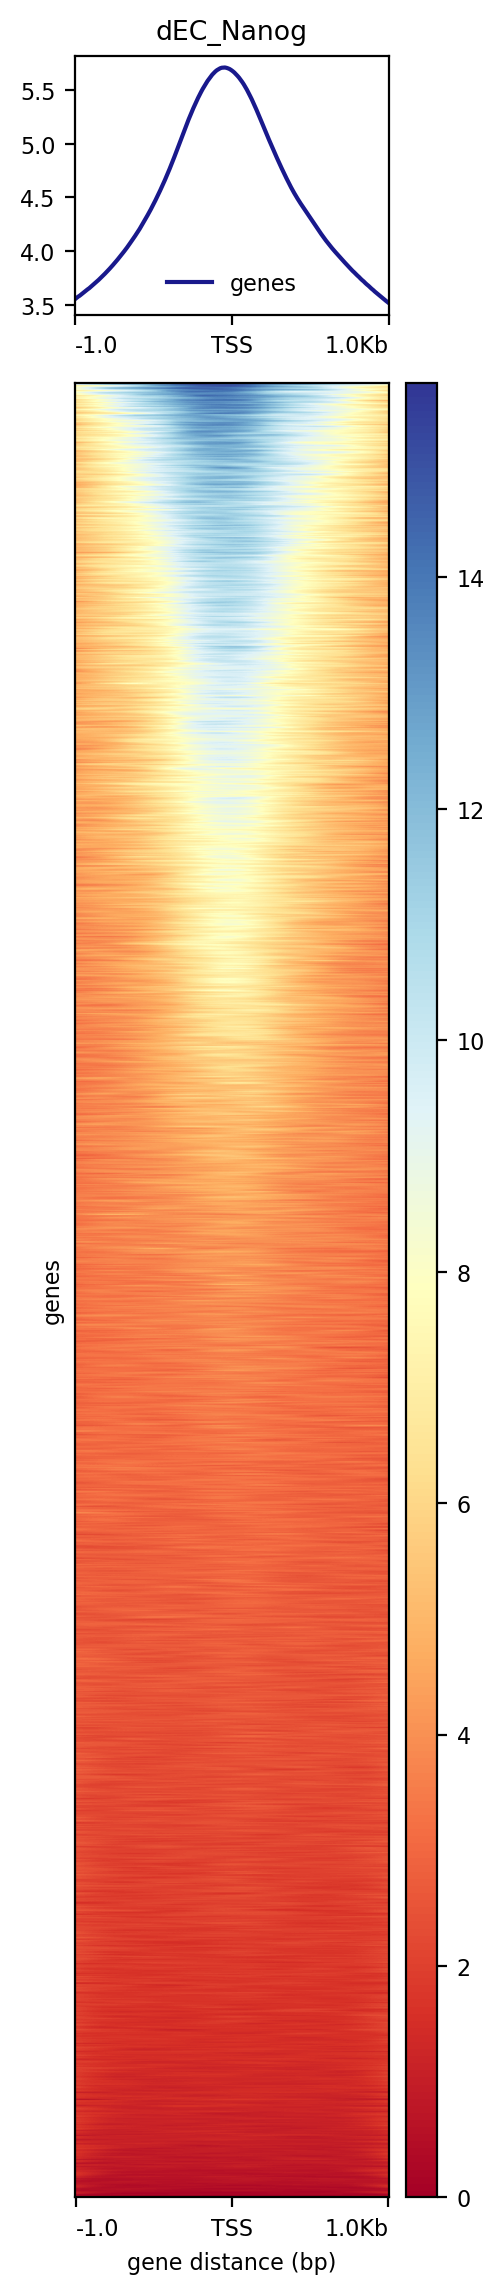

In [13]:
Image("ChIP-seq/plotHeatmap_dEC_Nanog.png", embed=True, retina=True)

Each row is the TSS of a single gene in this heatmap, and the color represents Nanog binding ChIP-Seq signal for that region. <br>
As expected Nanog is a transcription factor, therefore its signal is highest at the TSS. However, not all genes show a signal, since Nanog will only bind to its target genes.

<font size=3>__Compute the matrix for Nanog binding to the TSS for all the experimental runs__</font> <br>
This will take longer since the computations are fairly intensive

In [ ]:
computeMatrix reference-point --referencePoint TSS \
-b 1000 -a 1000 \
-S results/bams/*Nanog.bw \
-R gencode.v19.annotation.tss.bed \
--skipZeros --numberOfProcessors 16 \
-o Nanog_matrix.mat.gz

In [ ]:
# plot heatmap
plotHeatmap -m Nanog_matrix.mat.gz -out plotNanogHeatmap.png

From the plots below, we see that Nanog binding decreases on differentiation. This is expected since Nanog is a pluripotency factor that inhibits differentiation. Further, the levels of Nanog ChIP-Seq signal are very different in the three putative germ layers!

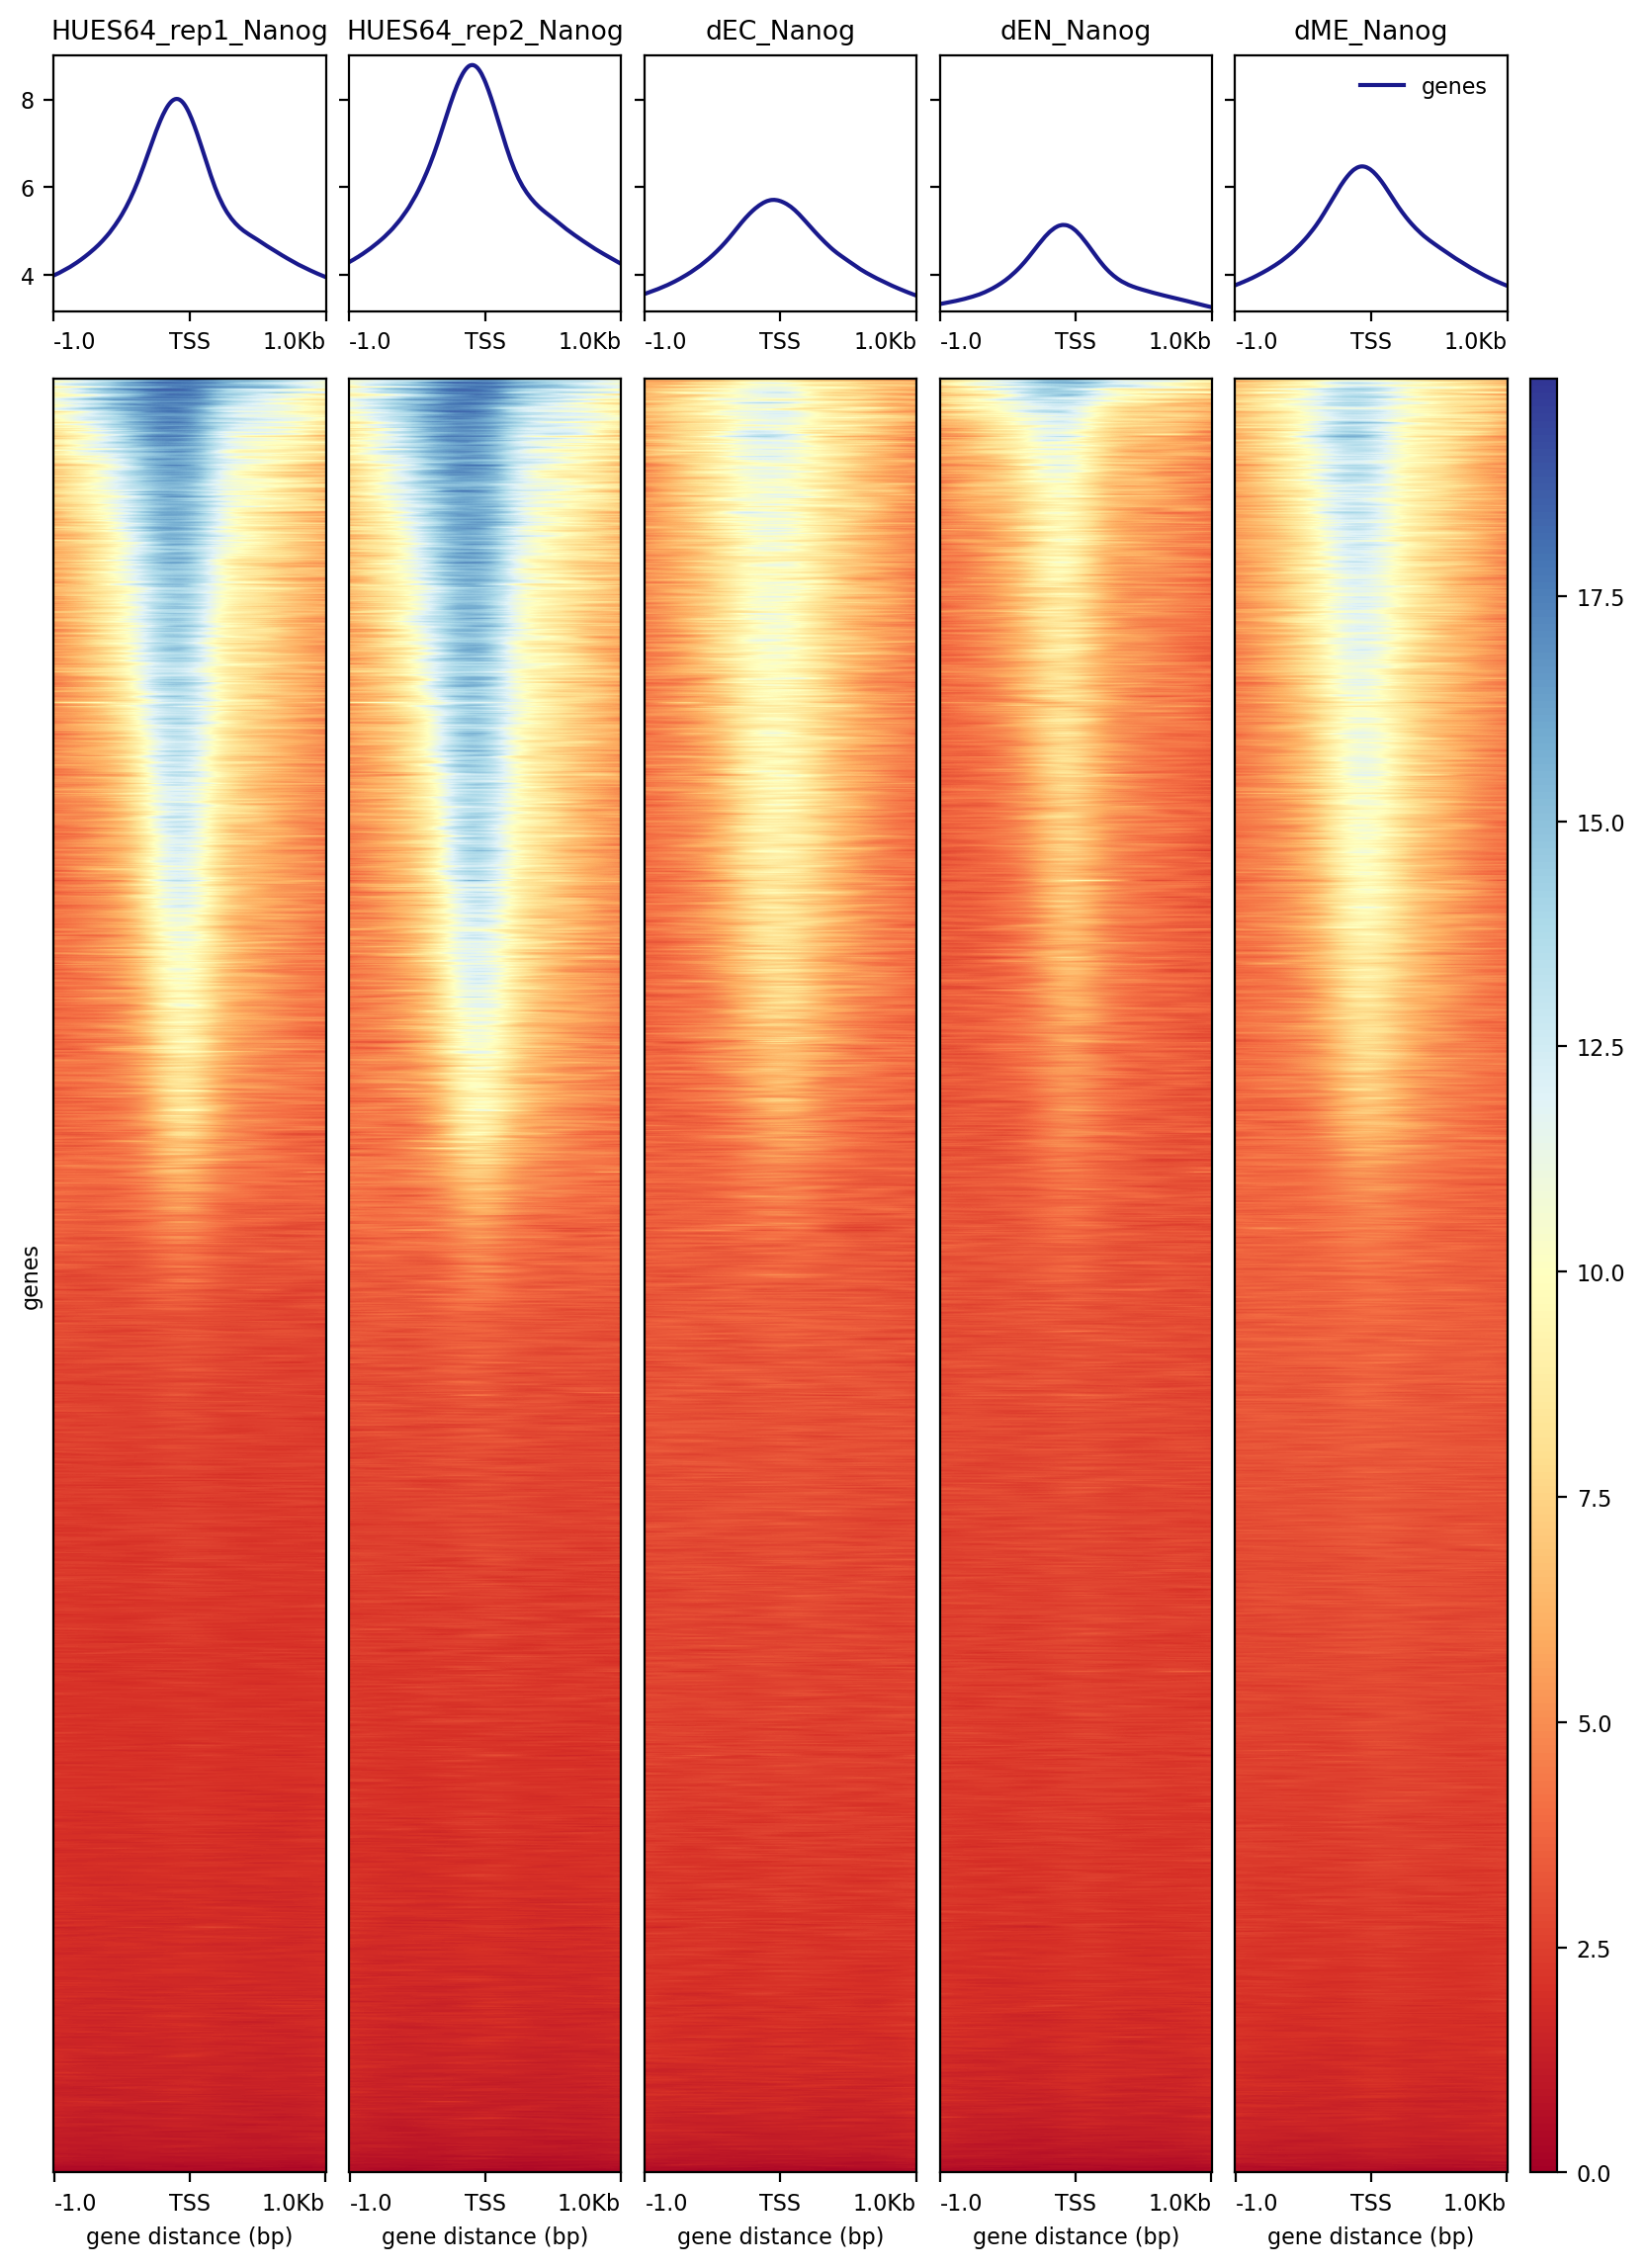

In [25]:
Image("ChIP-seq/plotNanogHeatmap.png", embed=True, retina=True)

We can also apply KMeans clustering on the heatmap profiles to separate gene-clusters with differential binding patterns

In [ ]:
# KMeans clustering on the heatmap
plotHeatmap -m Nanog_matrix.mat.gz \
-out plotNanogHeatmapKMeans.png \
--colorMap RdBu \
--whatToShow 'heatmap and colorbar' \
--kmeans 4

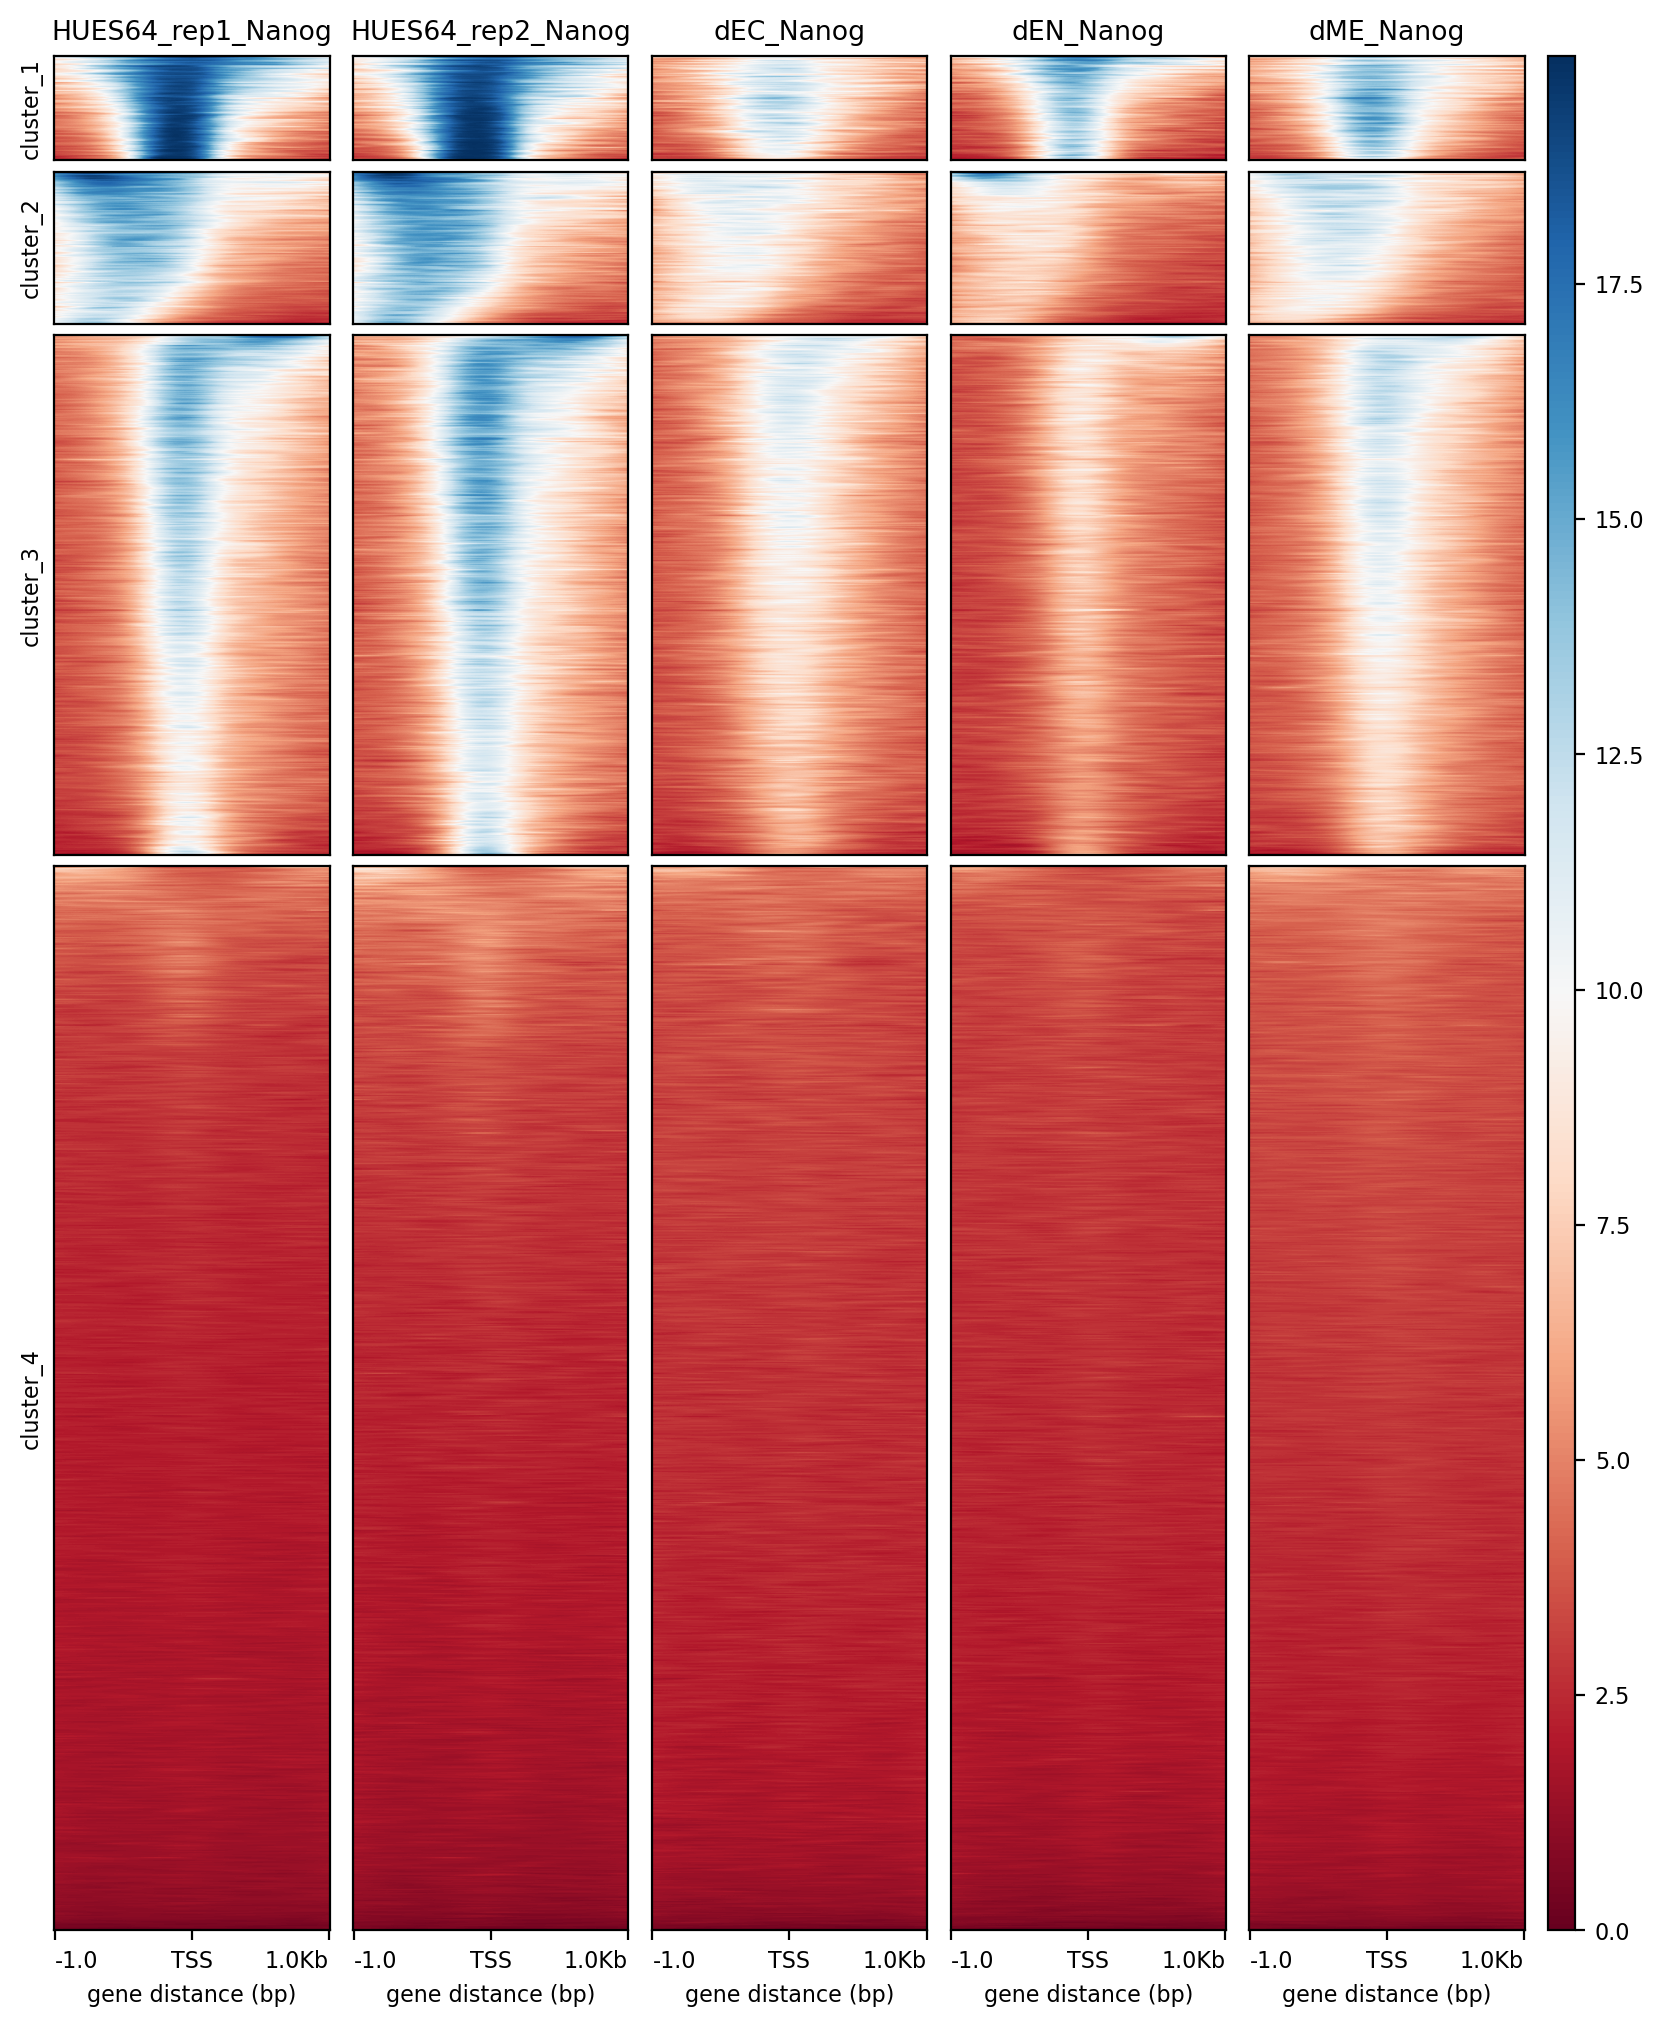

In [26]:
Image("ChIP-seq/plotNanogHeatmapKMeans.png", embed=True, retina=True)

You can also change the colors for each heatmap using the `colorMap` or `colorList` parameter. As well as remove thebounding boxes with `boxAroundHeatmaps`

In [ ]:
plotHeatmap -m Nanog_matrix.mat.gz \
-out plotNanogHeatmapKMeans_colorlist.png \
--colorMap Oranges_r Oranges_r Blues_r PiYG viridis \
--whatToShow 'heatmap and colorbar' \
--kmeans 4 \
--boxAroundHeatmaps no

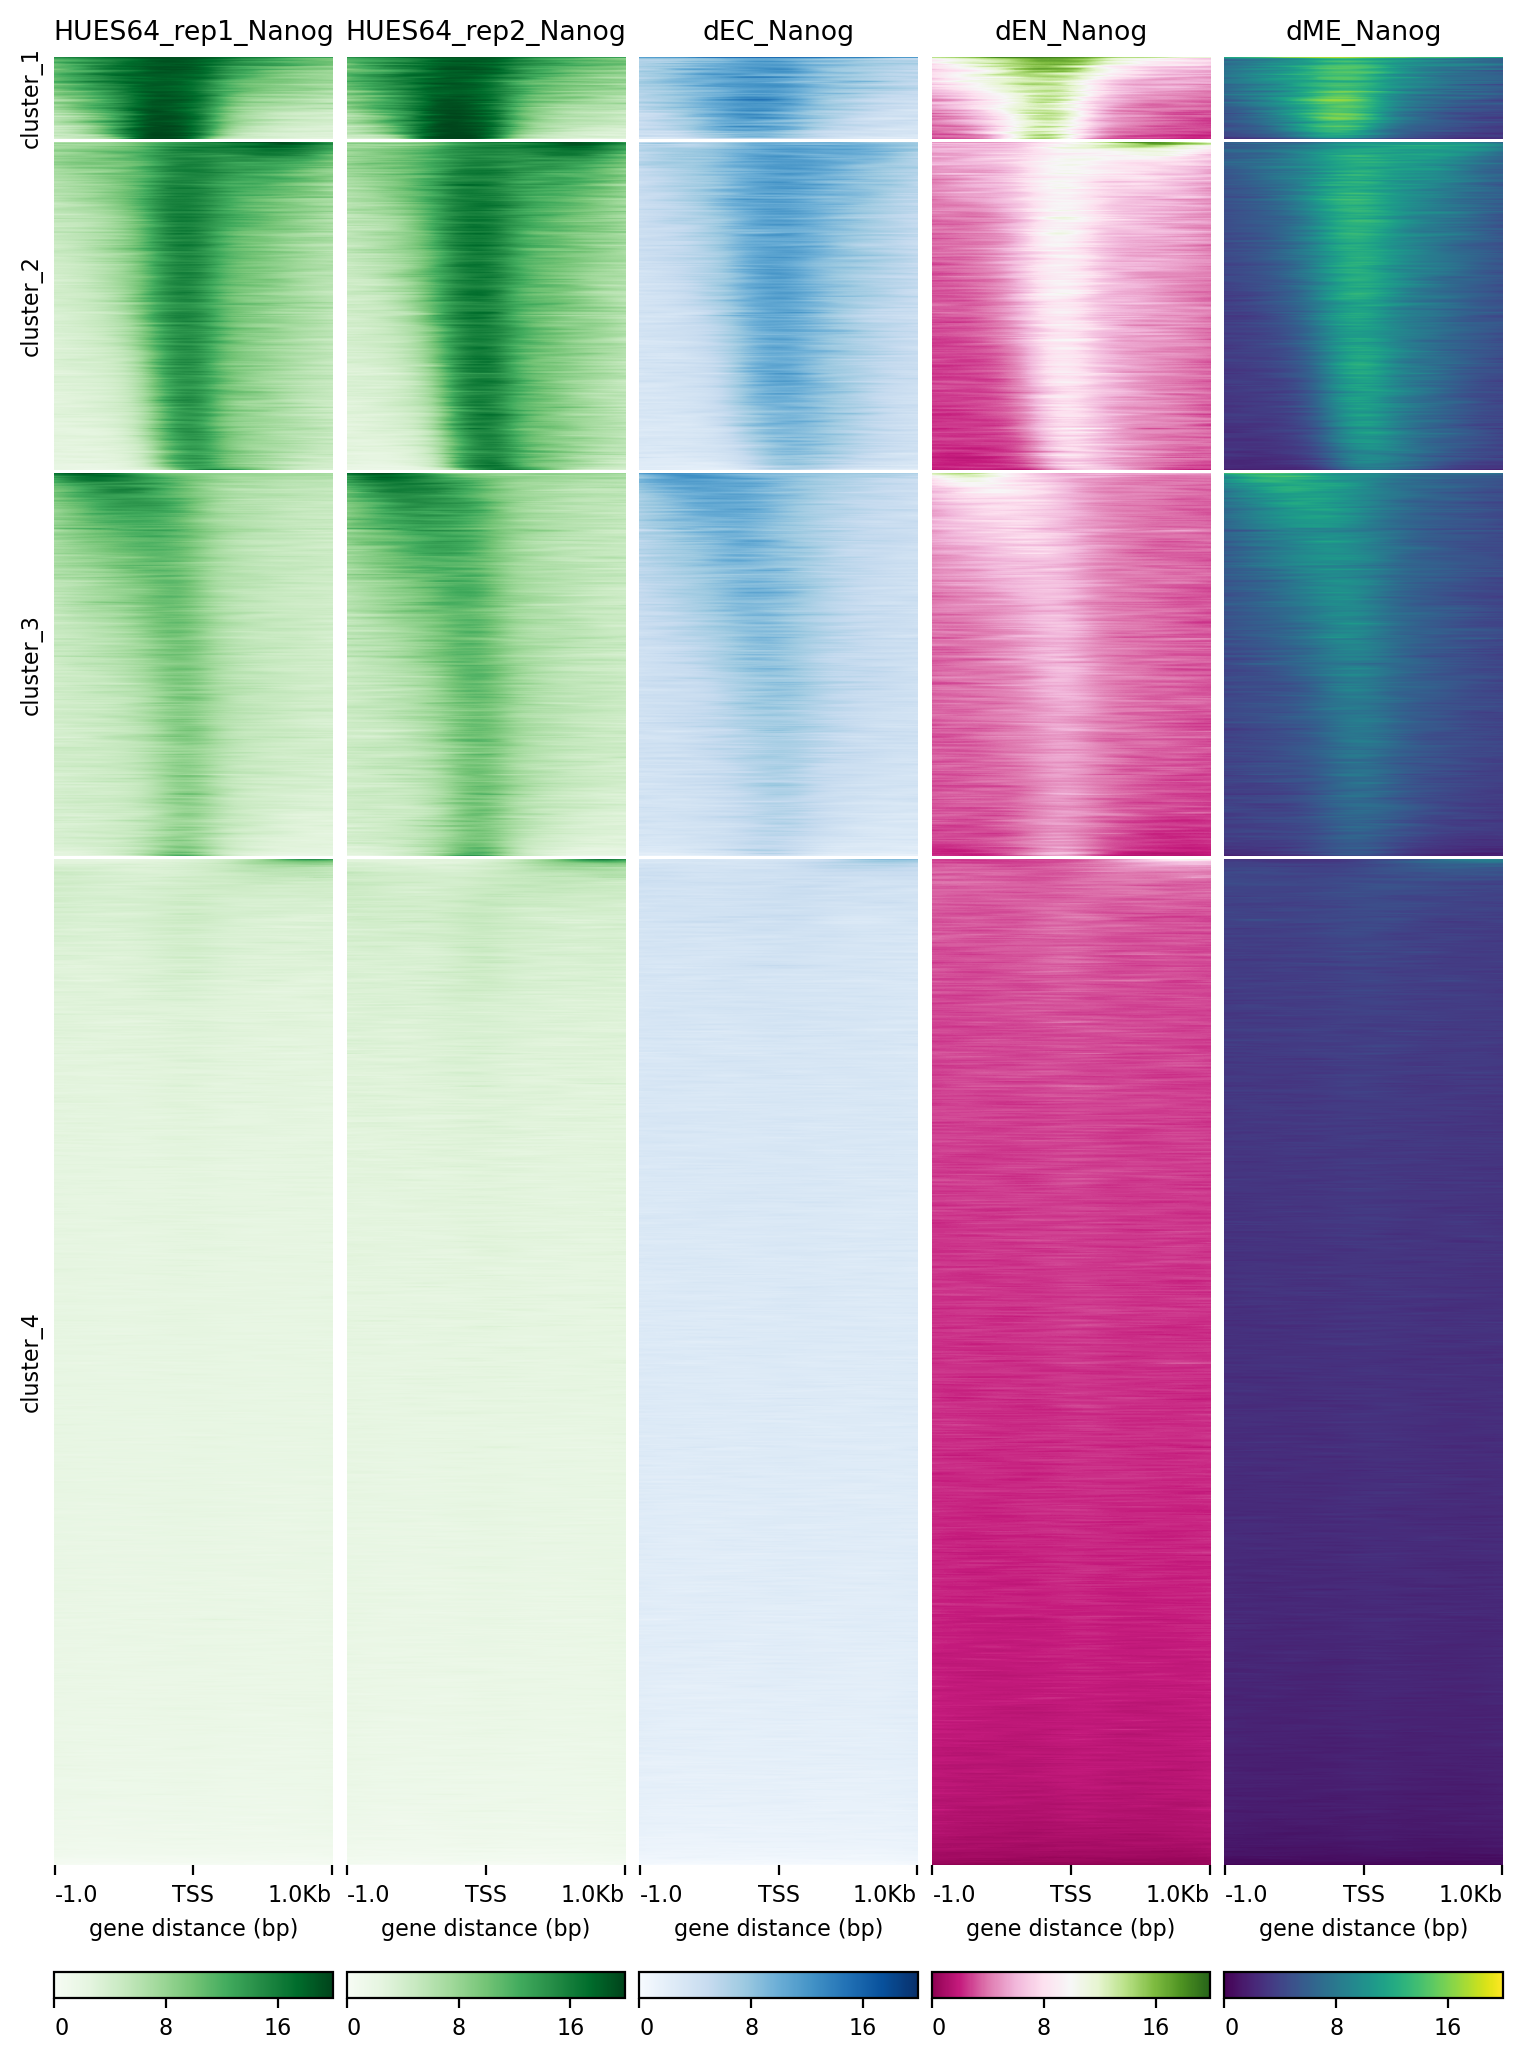

In [61]:
Image("ChIP-seq/plotNanogHeatmapKMeans_colorlist.png", embed=True, retina=True)

## Genomic Tracks with Coolbox
bigWig tracks can be visualized with genome browsers such as IGV or UCSC Genome Browser, however the package Coolbox offers easy in-notebook track visualization. Here we will visualize the ChIP-Se data we processed earlier as an example.

### Load data and packages

In [2]:
import os
import coolbox
from coolbox.api import *

In [43]:
DATA_DIR = "ChIP-seq/results/bams"
# alternatively use DATA_DIR = "ChIP-seq/example_bigwig_files"

In [44]:
# get bigWig files in folder
files = os.listdir(DATA_DIR)
bigwig_files = [f"{DATA_DIR}/{f}" for f in files if f.split('.')[-1] in ["bigwig", "bw"]]
bigwig_files

['ChIP-seq/results/bams/dEN_Nanog.bw',
 'ChIP-seq/results/bams/dEC_Nanog.bw',
 'ChIP-seq/results/bams/HUES64_rep1_Nanog.bw',
 'ChIP-seq/results/bams/HUES64_rep2_Nanog.bw',
 'ChIP-seq/results/bams/dME_Nanog.bw']

### Creating tracks with coolbox
A track is a basic plot element. Several types of tracks are supported by coolbox. Here we will set up a BigWig track for graphing. 

In [46]:
# define plotting range in genome (coordinates chosen from Tsankov et al Extended Data Figure 3b)
TEST_RANGE = "chr18:19600000-19800000"
RANGE_MARK = "chr18_19600000-19800000"

Add a single track of type `BigWig`

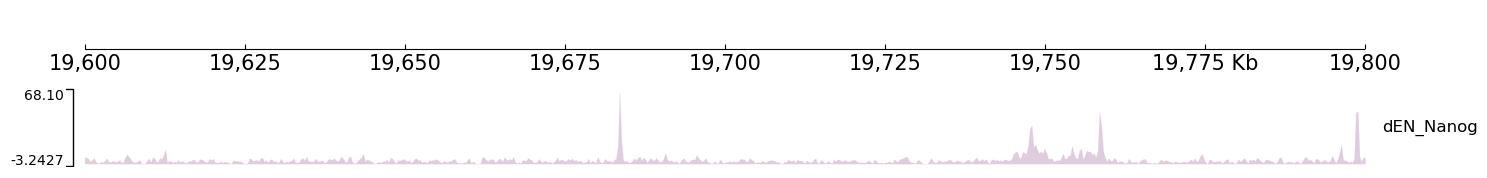

In [48]:
frame = XAxis() + BigWig(bigwig_files[0], title='dEN_Nanog')
frame.plot(TEST_RANGE)

Add a several tracks of type `BigWig` to compare across experiments. Add the argument `title` to name each track.

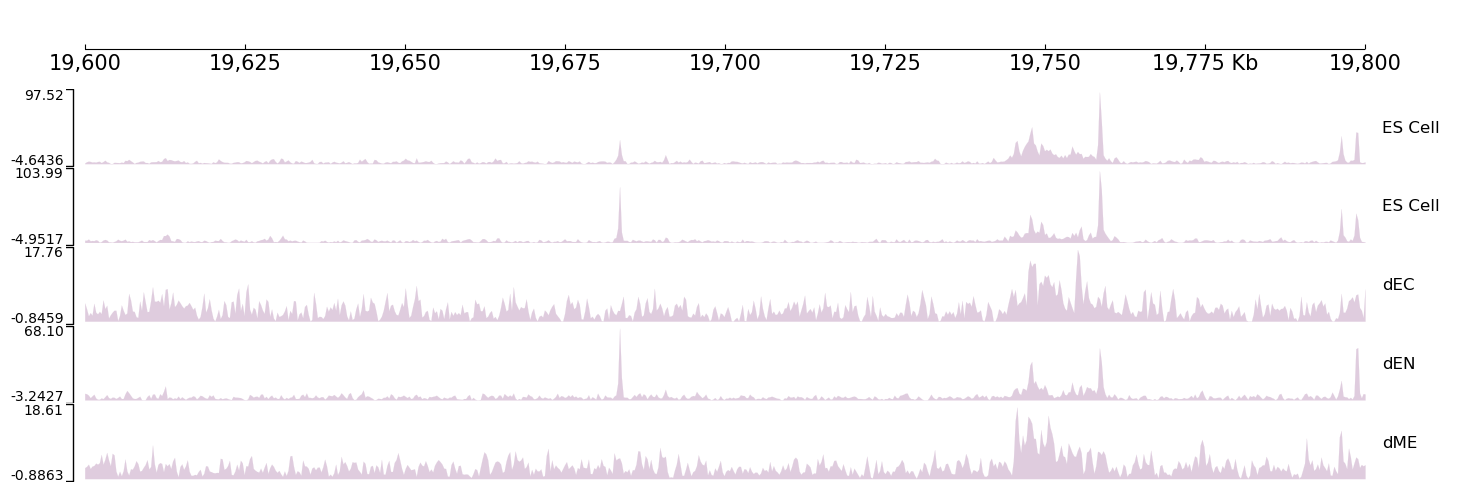

In [49]:
frame = XAxis() + BigWig(bigwig_files[2], title = 'ES Cell') + \
                  BigWig(bigwig_files[3], title = "ES Cell") + \
                  BigWig(bigwig_files[1], title = "dEC") + \
                  BigWig(bigwig_files[0], title = "dEN") + \
                  BigWig(bigwig_files[4], title = "dME")
frame.plot(TEST_RANGE)

Change the color of each track for better visualization with `Color`

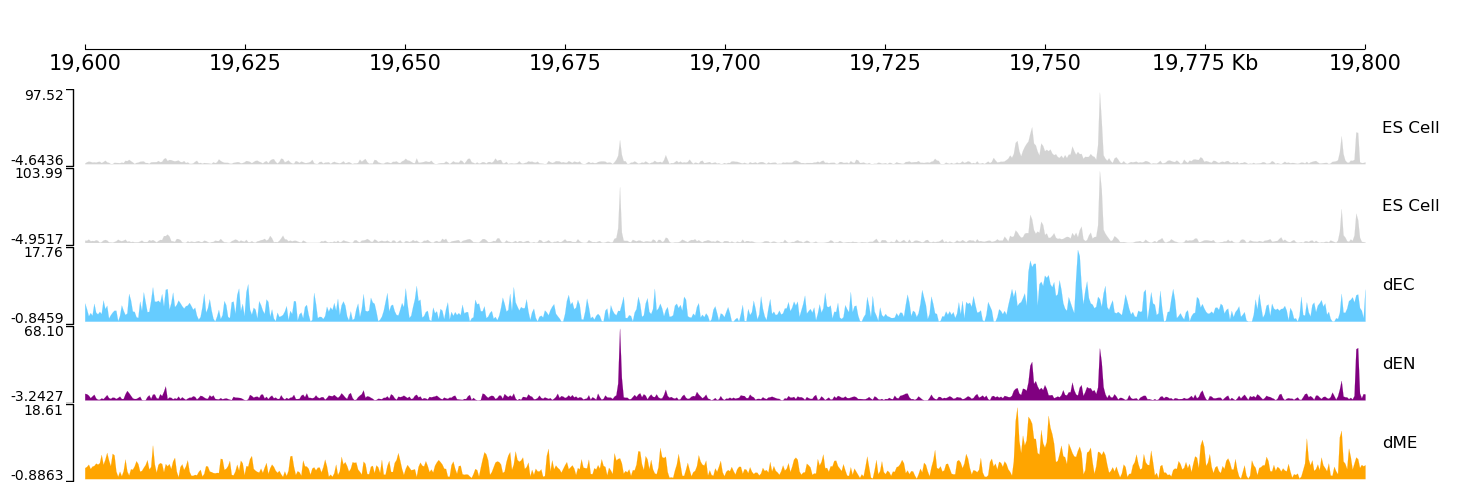

In [51]:
frame = XAxis() + BigWig(bigwig_files[2], title = 'ES Cell') + Color('lightgrey') +\
                  BigWig(bigwig_files[3], title = "ES Cell") + Color('lightgrey') +\
                  BigWig(bigwig_files[1], title = "dEC") + Color("#66ccff") + \
                  BigWig(bigwig_files[0], title = "dEN") + Color("purple") +\
                  BigWig(bigwig_files[4], title = "dME") + Color("orange")

frame.plot(TEST_RANGE)

Add vertical lines to denote regions of interest with `Vlines`

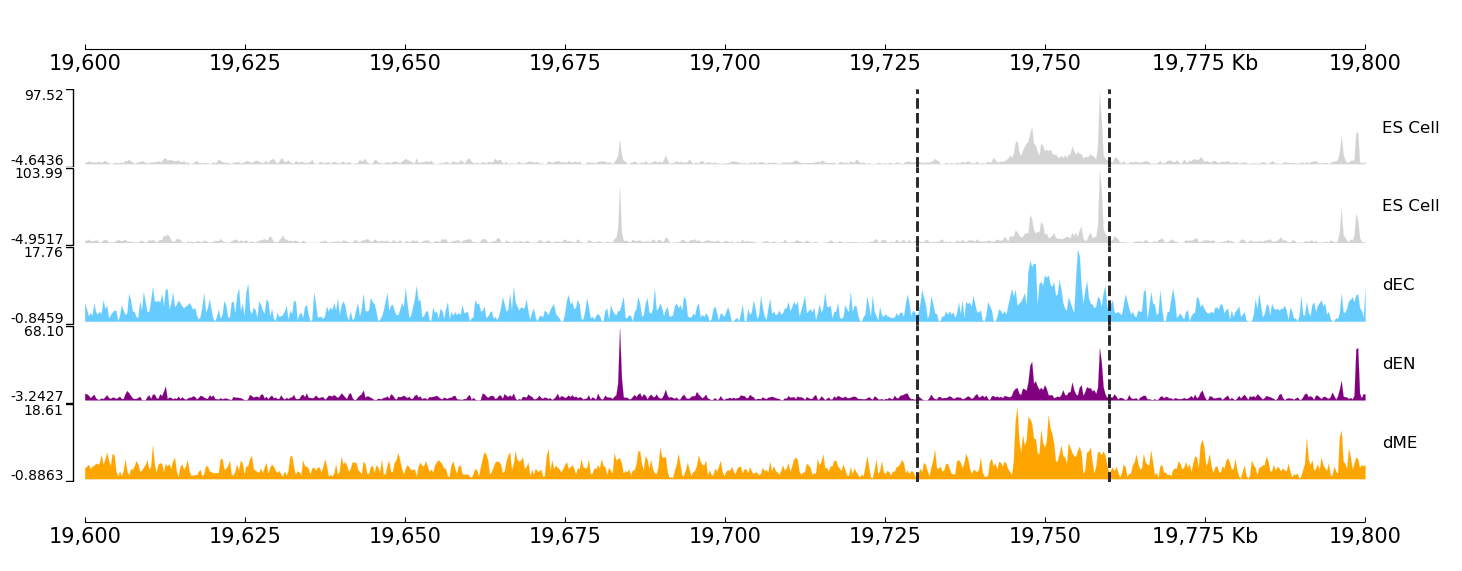

In [53]:
locus = [("chr18", 19730000), ("chr18", 19760000)]
with Vlines(locus, line_width=2):
    frame =       BigWig(bigwig_files[2], title = 'ES Cell') + Color('lightgrey') +\
                  BigWig(bigwig_files[3], title = "ES Cell") + Color('lightgrey') +\
                  BigWig(bigwig_files[1], title = "dEC") + Color("#66ccff") + \
                  BigWig(bigwig_files[0], title = "dEN") + Color("purple") +\
                  BigWig(bigwig_files[4], title = "dME") + Color("orange")
    
frame = XAxis() + frame + XAxis() # second XAxis for upper and lower coordinate dislay
frame.plot(TEST_RANGE)

Add highlights with `HighLights`

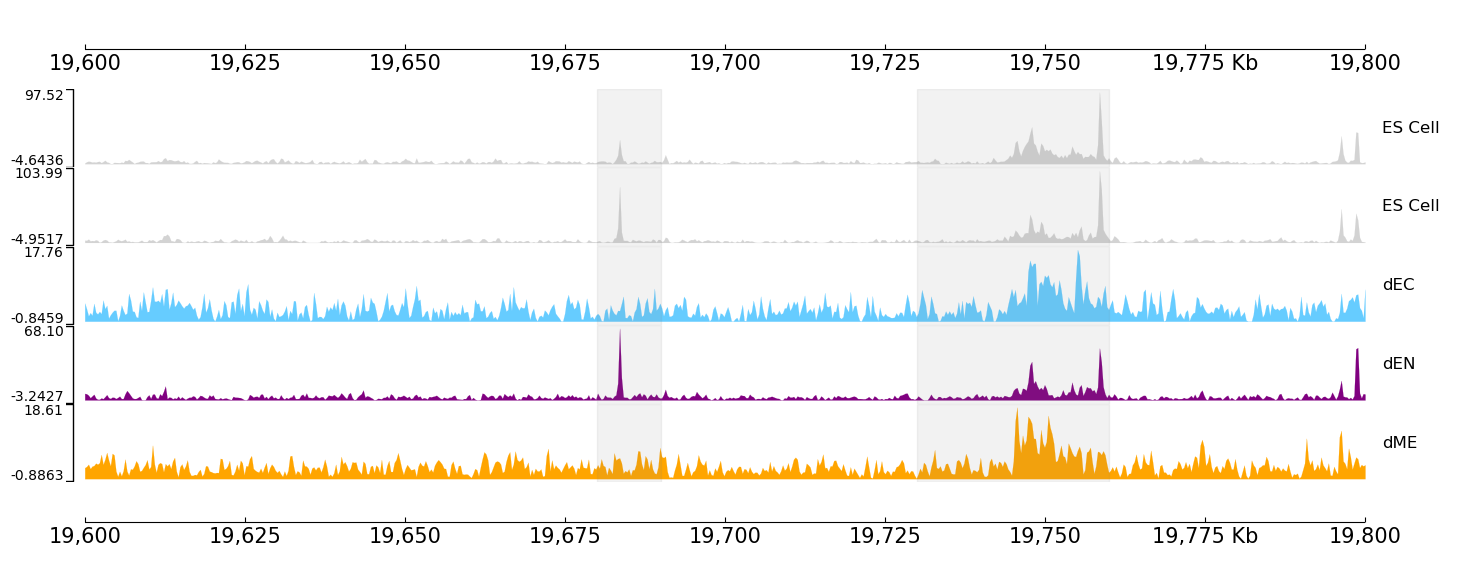

In [57]:
regions= ["chr18:19680000-19690000", "chr18:19730000-19760000", ]
highlights = HighLights(regions, color="grey", alpha=0.1)

with highlights:
    frame =       BigWig(bigwig_files[2], title = 'ES Cell') + Color('lightgrey') +\
                  BigWig(bigwig_files[3], title = "ES Cell") + Color('lightgrey') +\
                  BigWig(bigwig_files[1], title = "dEC") + Color("#66ccff") + \
                  BigWig(bigwig_files[0], title = "dEN") + Color("purple") +\
                  BigWig(bigwig_files[4], title = "dME") + Color("orange")
    
frame = XAxis() + frame + XAxis()
frame.plot(TEST_RANGE)

### Using the interactive browser inside a Jupyter notebook

In [58]:
# using the frame object created before, we can call it with a Browser instance as below
bsr = Browser(frame)
bsr.goto(TEST_RANGE)
bsr.show()

In [63]:
from ipywidgets import IntSlider
from ipywidgets.embed import embed_minimal_html

embed_minimal_html('export.html', views=bsr.show(), title='Widgets export')